In [1]:
#using pytorch
#cnnlstm on sequence level (not frame)

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # order devices by bus id
os.environ["CUDA_VISIBLE_DEVICES"]="1" # only make device 0 visible

In [1]:
%matplotlib inline
from platform import python_version
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import itertools
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import image as matplotimage
from os import listdir

from IPython.display import HTML, display
import pandas as pd
import statistics
import time
import re
import cv2

In [2]:
#pytorch
from torch.nn import Module
from torch.nn import LSTM
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Softmax
from torch.nn import BatchNorm1d
from torch.nn import BatchNorm2d
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torch.nn.init import orthogonal_
from torch.nn.init import normal_
from torch.nn.init import calculate_gain
from torch.nn.init import zeros_
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss
from torch.autograd import Variable
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, ChainDataset
import torch.nn.functional as F
from torch.utils.data import Subset
from skimage.metrics import structural_similarity as ssim
from torch import nn
from skorch import NeuralNetClassifier
from skorch.helper import SliceDataset
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, make_scorer
from collections import Counter

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
print(device)

cuda


In [12]:
print("The currently selected GPU is number:", torch.cuda.current_device(),
      ", it's a ", torch.cuda.get_device_name(device=None))

The currently selected GPU is number: 0 , it's a  NVIDIA GeForce GTX 1080


In [13]:
import torch
print("GPUs available: ", torch.cuda.device_count())
for device in range(torch.cuda.device_count()):
    print("Device",device, ":", torch.cuda.get_device_name(device=device))

GPUs available:  1
Device 0 : NVIDIA GeForce GTX 1080


In [3]:
classes = ['vattene', 'vieniqui', 'perfetto', 'furbo', 'fheduepalle', 'chevuoi', 'daccordo', 'seipazzo', 'combinato', 'freganiente', 'ok', 'cosatifarei', 'basta', 'prendere', 'noncenepiu', 'fame', 'tantotempo', 'buonissimo', 'messidaccordo', 'sonostufo']

In [4]:
import csv
sampling_index = []
all_labels_training = []
with open('/path/to/training_labels_edited.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(reader, None)
    for row in reader:
        sampling_index.append(row[0])
        all_labels_training.append(str.split(row[1]))
        print(', '.join(row))

1, 2 14 20 6 7 3 1 13 18 5 12 16 15 4 9 10 8 17 19 11
2, "sample missing,  just making the doc consistent"
3, 12 3 18 14 16 20 5 2 4 1 10 6 9 19 15 17 11 13 8 7
4, 13 1 8 18 7 17 16 9 5 10 11 4 20 3 19 2 14 6 15 12
5, 10 4 7 13 19 15 9 11 17 1 8 5 18 3 12 16 14 2 20 6
6, 14 15 10 16 11 2 20 8 7 9 1 19 17 18 6 4 13 3 5 12
7, 19 11 12 9 6 3 15 16 14 4 2 10 20 1 13 8 5 7 18 17
8, 17 7 8 2 9 15 11 3 12 1 6 20 16 4 14 13 10 5 18 19
9, 11 3 7 15 8 17 12 16 20 4 5 13 10 1 18 6 19 2 14 9
10, 3 11 5 9 12 15 4 2 20 19 13 16 17 18 1 7 8 14 6 10
11, 12 1 5 9 10 18 13 7 2 20 14 19 15 6 16 4 3 11 17 8
12, 8 13 10 11 12 15 17 2 16 9 20 14 4 7 5 1 19 6 3 18
13, 15 11 19 7 5 14 4 8 6 17 2 20 13 1 10 9 12 16 18 3
14, 17 20 1 15 3 18 8 16 11 14 2 12 9 19 6 5 10 13 4 7
15, 3 7 16 9 12 10 4 19 15 2 14 20 6 17 1 18 13 8 11 5
16, 9 12 19 2 1 13 11 16 17 5 20 7 14 3 18 15 4 6 8 10
17, 10 16 6 20 18 2 12 19 9 17 13 4 1 7 5 8 3 11 14 15
18, 14 2 8 4 12 18 11 7 16 20 1 15 17 9 10 13 3 19 6 5
19, 17 6 12 2 5 18 1

In [5]:
import csv
sampling_index = []
all_labels_test = []
with open('/path/to/test_labels_edited.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(reader, None)
    for row in reader:
        sampling_index.append(row[0])
        all_labels_test.append(str.split(row[1]))
        print(', '.join(row))

800, 16 11 14 12 7 13 8 15 3 9
801, 5 6 17 7 20 11 2 15 3 12 10
802, 17 13 1 11 4 5 9 19 3 6
803, 16 6 1 2 7 14 19 17 11 8
804, 6 2 8 1 13 5 11 16 14
805, 17 15 13 18 19 4 3 11 12 5
806, 13 3 10 4 14 5 7 11 18 15
807, 13 18 15 17 9 12 2 16 14
808, 4 12 7 11 20 2 17 19 8 6 5
809, 3 15 13 11 7 6 19 1 14 12
810, 10 4 13 3 17 9 1 2 18
811, 19 15 7 10 17 13 5 8 16 12 1
812, 9 18 3 5 11 8 17 13
813, 10 14 20 17 2 12 7 15 1 5 19
814, 14 18 11 2 17 15 5 6 13 1
815, 10 11 20 4 18 2 8 14 5 16
816, 5 17 10 8 4 2 20 15 16 19
817, 13 7 20 4 1 14 16 6 3
818, 17 13 2 12 6 10 9 15 20 3
819, 9 17 16 20 13 15 6 8 1 7
820, 2 11 9 12 19 17 16 4 10 7
821, 11 2 8 7 6 3 9 16 13 10
822, 16 4 13 11 8 9 2 14 19 1
823, 7 10 6 14 2 11 9 20 5 8
824, 20 14 7 6 13 2 4 19 12 5
825, 2 8 6 1 13 19 10 3 16
826, 10 11 9 18 3 5 15 8 12 4
827, 7 17 9 13 18 3 12 2 4
828, 1 17 14 13 15 16 5 18 20 4 19
829, 14 5 3 13 4 18 9 20 11 10 19
830, 4 5 10 9 3 2 8 16 1 18 15
831, 12 20 11 9 8 4 16 6 18 15
832, 8 5 7 6 4 10 18 3 13 11


In [6]:
import csv
sampling_index = []
all_labels_validation = []
with open('/path/to/validation_labels_edited.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(reader, None)
    for row in reader:
        sampling_index.append(row[0])
        all_labels_validation.append(str.split(row[1]))
        print(', '.join(row))

410, 18 3 4 12 20 14 8 9 17
411, 10 12 1 11 6 19 20 16 9 8 14
412, 10 3 12 17 7 19 2 9 5 4
413, 7 18 1 2 4 15 8 19 3 20
414, 18 9 5 4 20 6 7 10 12 17
415, 16 1 6 5 15 8 3 10 18 17
416, 17 19 3 16 15 18 8 7 9 14
417, 3 16 1 5 15 18 10 13 9 4 8
418, 4 3 13 9 2 8 6 12 17 20
419, 4 3 13 9 2 8 6 12 17 20
420, 13 19 16 10 5 7 12 3 14 8
421, 5 15 17 6 8 18 13 12 3 1
422, 3 20 10 11 19 6 18 16 9 1
423, 10 19 16 2 20 1 4 9 14
424, 13 16 4 1 12 5 2 3 20
425, 16 1 17 2 5 7 15 13 14 18
426, 2 9 16 12 8 4 7 1 15
427, 8 12 7 5 19 20 9 17 6 11
428, 12 5 8 16 6 11 19 9 10 3 18
429, 20 17 19 14 15 1 6 8 4 9
430, 4 3 13 6 16 14 19 18 17 5
431, 10 5 13 11 16 8 2 6 19
432, 1 16 9 17 3 14 2 12 4
433, 1 9 13 8 5 6 2 14 10 7
434, 17 5 11 9 4 2 10 15 19 8
435, 13 7 12 6 4 15 9 3 10 11
436, 4 18 5 11 8 7 16 2 10
437, 2 12 18 16 17 20 13 11 10 1
438, 18 3 4 12 10 9 20 19 14 11 6
439, 16 17 6 14 20 12 7 11 2
440, 4 12 8 14 9 1 2 11 15 17 19
441, 14 20 11 7 12 2 8 19 16 10 4
442, 2 1 15 7 5 4 3 11 16
443, 19 18 8

In [12]:
def mse(img1, img2):
    err = np.sum((img1.astype("float") - img2.astype("float")) ** 2)
    err /= float(img1.shape[0] * img2.shape[1])
    return err

def diffImg(t0, t1):
    return cv2.absdiff(t0, t1)

def getdiffDir(imgs):
    #print(np.shape(imgs))
    diff = []
    all_ssim = []
    all_mse = []
    t = diffImg(imgs[0], imgs[1])
    for i, img in enumerate(imgs[2:-1]):
        #print("ssim", ssim(img, imgs[0]))
        im = diffImg(imgs[i-1], img)
        t += im
        all_ssim.append(1 - ssim(img.reshape(64,48), imgs[0].reshape(64,48)))
        all_mse.append(mse(img.reshape(64,48), imgs[0].reshape(64,48)))
    diff.append(t)
    return all_ssim, all_mse, diff

In [13]:
#read Montalbano training subs
class MontalbanoDataset(Dataset):
    def __init__(self, path='/path/to/montalbano_preprocessed_frames/training',
                kendon_path='/path/to/montalbano_kendon/training'):
        self.x_samples = []
        self.y_labels = []
        self.file_names = []
        self.path =  []
        self.labelindex =  []
        self.gesture_peak = []
        self.use_snapture = []
        #self.z_labels = []
        for folder in listdir(os.path.join(path)): #Sample00021_color, Sample00022_color, etc.
            print(folder)
            if (folder.startswith("")): #use for testing
                print(folder)
                sample_index = int(folder[6:-6])
                t = []
                all_sequences = []
                one_sequence = []
                started = False
                for filename in sorted(os.listdir(os.path.join(path,folder)) ,key=lambda x: int(re.split(r'(\d+)', x)[1])):
                    if filename.endswith(".jpg"):
                        if ('-start' in filename): 
                                started = True
                        if ('-end' in filename):
                                all_sequences.append(one_sequence)
                                started = False
                                one_sequence = []
                        if (started):
                                file = Image.open(os.path.join(path, folder, filename))
                                img_data = np.asarray(file)
                                img_data = np.transpose(img_data / 255.0)
                                # store loaded image  
                                one_sequence.append(img_data)

                print(folder, ' contains ', str(len(all_sequences)), ' gestures')
                if len(all_sequences) != len(all_labels_training[sample_index-1]):
                    print("error")
                for gesture_index, sequence in enumerate(all_sequences):
                    if len(sequence) < 45:
                        sequence = np.pad(sequence, ((45-len(sequence), 0),(0,0),(0,0)), 'constant', constant_values=[0])  
                    sequence = np.asarray(sequence[:45])
                    kendon_stroke_index = round(len(sequence) / 2)
                    seq = sequence[kendon_stroke_index-2:kendon_stroke_index+2]
                    all_ssim, all_mse, diff = getdiffDir(seq)
                    if (np.mean(all_ssim) <= 0.027 ):
                        self.use_snapture.append(True)
                    else:
                        self.use_snapture.append(False)
                    self.x_samples.append(np.reshape(sequence, (-1, 1, 64, 48)))
                    self.y_labels.append(int(all_labels_training[sample_index-1][gesture_index])-1)
                    self.file_names.append(folder+'/'+filename)
                    self.path.append(folder)
                    self.labelindex.append(str(sample_index-1) + '/' + str(gesture_index))
                    img_file_kendon = Image.open(os.path.join(kendon_path, folder, str(gesture_index+1)+"_hand.jpg")).convert('L') #files start from 1
                    img_data_kendon = np.asarray(img_file_kendon)
                    self.gesture_peak.append(np.reshape(np.transpose(img_data_kendon / 255.0), (1, 64, 48)))
        self.y_labels = np.asarray(self.y_labels)
    def __len__(self):
        return len(self.x_samples)

    def __getitem__(self, idx):
        return self.x_samples[idx], self.y_labels[idx], self.path[idx], self.labelindex[idx], self.gesture_peak[idx], self.use_snapture[idx]#, self.file_names[idx]
        #return self.x_samples[idx], self.y_labels[idx], self.z_labels[idx]

In [14]:
class MontalbanoValidationset(Dataset):
    def __init__(self, path='/path/to/montalbano_preprocessed_frames/validation',
                kendon_path='/path/to/montalbano_kendon/validation'):
        self.x_samples = []
        self.y_labels = []
        self.path =  []
        self.labelindex =  []
        self.file_names =  []
        self.gesture_peak = []
        self.use_snapture = []
        for folder in listdir(path): #Sample00021_color, Sample00022_color, etc.
            print(folder)
            if (folder.startswith(str(""))):
                print(folder)
                sample_index = int(folder[6:-6])
                print(sample_index)
                sample_index = sample_index - 409

                all_sequences = []
                one_sequence = []
                started = False
                for filename in sorted(os.listdir(os.path.join(path,folder)) ,key=lambda x: int(re.split(r'(\d+)', x)[1])):
                    if filename.endswith(".jpg"):
                            if ('-start' in filename): 
                                    started = True
                            if ('-end' in filename): 
                                    all_sequences.append(one_sequence)
                                    started = False
                                    one_sequence = []
                            if (started):
                                    file = Image.open(os.path.join(path, folder, filename))
                                    img_data = np.asarray(file)
                                    img_data = np.transpose(img_data / 255.0)
                                    one_sequence.append(img_data)

                print(folder, ' contains ', str(len(all_sequences)), ' gestures')
                if len(all_sequences) != len(all_labels_validation[sample_index-1]):
                    print("error")
                for gesture_index, sequence in enumerate(all_sequences):
                    if len(sequence) < 45:
                        sequence = np.pad(sequence, ((45-len(sequence), 0),(0,0),(0,0)), 'constant', constant_values=[0])  
                    sequence = np.asarray(sequence[:45])

                    kendon_stroke_index = round(len(sequence) / 2)
                    seq = sequence[kendon_stroke_index-2:kendon_stroke_index+2]
                    all_ssim, all_mse, diff = getdiffDir(seq)
                    if (np.mean(all_ssim) <= 0.027 ):
                        self.use_snapture.append(True)
                    else:
                        self.use_snapture.append(False)

                    self.x_samples.append(np.reshape(sequence, (-1, 1, 64, 48)))
                    self.y_labels.append(int(all_labels_validation[sample_index-1][gesture_index])-1)
                    self.file_names.append(folder+'/'+filename)
                    self.path.append(folder)
                    self.labelindex.append(str(sample_index-1+409) + '/' + str(gesture_index))
                    img_file_kendon = Image.open(os.path.join(kendon_path, folder, str(gesture_index+1)+"_hand.jpg")).convert('L') #Files start from 1
                    img_data_kendon = np.asarray(img_file_kendon)
                    self.gesture_peak.append(np.reshape(np.transpose(img_data_kendon / 255.0), (1, 64, 48)))

        self.y_labels = np.asarray(self.y_labels)
    def __len__(self):
        return len(self.x_samples)

    def __getitem__(self, idx):
        return self.x_samples[idx], self.y_labels[idx], self.path[idx], self.labelindex[idx], self.gesture_peak[idx], self.use_snapture[idx]
        #return self.x_samples[idx], self.y_labels[idx], self.z_labels[idx]

In [15]:
#read Montalbano test subset
class MontalbanoTestset(Dataset):

    def __init__(self, path='/path/to/montalbano_preprocessed_frames/test',
                kendon_path='/path/to/montalbano_kendon/test'):
        self.x_samples = []
        self.y_labels = []
        self.path =  []
        self.labelindex =  []
        self.file_names =  []
        self.gesture_peak = []
        self.use_snapture = []

        for folder in listdir(path): #Sample00021_color, Sample00022_color, etc.
            print(folder)
            if (folder.startswith(str(""))):
                print(folder)
                sample_index = int(folder[6:-6])
                print(sample_index)
                sample_index = sample_index - 799
                t = []
                #loaded_labels = []

                all_sequences = []
                one_sequence = []
                started = False
                for filename in sorted(os.listdir(os.path.join(path,folder)) ,key=lambda x: int(re.split(r'(\d+)', x)[1])):
                    if filename.endswith(".jpg"):
                            if ('-start' in filename): 
                                    started = True
                            if ('-end' in filename): 
                                    all_sequences.append(one_sequence)
                                    started = False
                                    one_sequence = []
                            if (started):
                                    file = Image.open(os.path.join(path, folder, filename))
                                    img_data = np.asarray(file)
                                    img_data = np.transpose(img_data / 255.0)
                                    # store loaded image  
                                    one_sequence.append(img_data)
                        
                print(folder, ' contains ', str(len(all_sequences)), ' gestures')
                if len(all_sequences) != len(all_labels_test[sample_index-1]):
                    print("error")
                for gesture_index, sequence in enumerate(all_sequences):
                    if len(sequence) < 45:
                        sequence = np.pad(sequence, ((45-len(sequence), 0),(0,0),(0,0)), 'constant', constant_values=[0])  
                    sequence = np.asarray(sequence[:45])

                    kendon_stroke_index = round(len(sequence) / 2)
                    seq = sequence[kendon_stroke_index-2:kendon_stroke_index+2]
                    all_ssim, all_mse, diff = getdiffDir(seq)
                    if (np.mean(all_ssim) <= 0.027 ):
                        self.use_snapture.append(True)
                    else:
                        self.use_snapture.append(False)

                    self.x_samples.append(np.reshape(sequence, (-1, 1, 64, 48)))
                    self.y_labels.append(int(all_labels_test[sample_index-1][gesture_index])-1)
                    self.file_names.append(folder+'/'+filename)
                    self.path.append(folder)
                    self.labelindex.append(str(sample_index-1+799) + '/' + str(gesture_index))
                    img_file_kendon = Image.open(os.path.join(kendon_path, folder, str(gesture_index+1)+"_hand.jpg")).convert('L') #Files start from 1
                    img_data_kendon = np.asarray(img_file_kendon)
                    self.gesture_peak.append(np.reshape(np.transpose(img_data_kendon / 255.0), (1, 64, 48)))

        self.y_labels = np.asarray(self.y_labels)
    def __len__(self):
        return len(self.x_samples)

    def __getitem__(self, idx):
        return self.x_samples[idx], self.y_labels[idx], self.path[idx], self.labelindex[idx], self.gesture_peak[idx], self.use_snapture[idx]
        #return self.x_samples[idx], self.y_labels[idx], self.z_labels[idx]

In [16]:
training_set = MontalbanoDataset()

Sample00308_color
Sample00308_color
Sample00308_color  contains  20  gestures
Sample00309_color
Sample00309_color
Sample00309_color  contains  20  gestures
Sample00310_color
Sample00310_color
Sample00310_color  contains  20  gestures


In [18]:
validation_set = MontalbanoValidationset()

Sample00629_color
Sample00629_color
629
Sample00629_color  contains  12  gestures
Sample00631_color
Sample00631_color
631
Sample00631_color  contains  12  gestures
Sample00630_color
Sample00630_color
630
Sample00630_color  contains  10  gestures


In [19]:
test_set = MontalbanoTestset()

Sample01054_color
Sample01054_color
1054
Sample01054_color  contains  9  gestures
Sample01056_color
Sample01056_color
1056
Sample01056_color  contains  10  gestures
Sample01055_color
Sample01055_color
1055
Sample01055_color  contains  10  gestures


In [60]:
print(np.shape(training_set))
print(np.shape(validation_set))
print(np.shape(test_set))

(7069, 6)
(3505, 6)
(2719, 6)


In [61]:
concat_dataset = torch.utils.data.ConcatDataset([training_set, validation_set, test_set])
split_targets = concat_dataset.datasets[0].y_labels
split_targets = np.append(split_targets, concat_dataset.datasets[1].y_labels)
split_targets = np.append(split_targets, concat_dataset.datasets[2].y_labels)
print(np.shape(split_targets))

(13293,)


In [62]:
train_indices, test_indices = train_test_split(np.arange(split_targets.shape[0]), test_size=0.3, stratify=split_targets)


In [63]:
print(len(train_indices))
print(len(test_indices))
train_dataset = Subset(concat_dataset, indices=train_indices)
test_dataset = Subset(concat_dataset, indices=test_indices)

9305
3988


In [64]:
# Check class balance
_, train_counts = np.unique(split_targets[train_indices], return_counts=True)
_, test_counts = np.unique(split_targets[test_indices], return_counts=True)
print(train_counts)
print(test_counts)
print('Train balance {}\nTest balance {}'.format(#not very expressive
    train_counts[1]/train_counts[0], test_counts[1]/test_counts[0]))

[459 466 468 463 463 469 448 478 470 459 456 466 470 471 459 484 478 466
 459 453]
[197 200 201 199 198 201 192 205 202 196 195 200 202 202 196 207 205 199
 197 194]
Train balance 1.0152505446623095
Test balance 1.015228426395939


In [66]:
print(np.shape(train_dataset))
print(np.shape(test_dataset))

(9305, 6)
(3988, 6)


/data/7ali/gproj/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [35]:
import random
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
cnn_init1 = None
linear_init = None
cnn_init5 = None
linear_init64 = None
linear_init128 = None
linear_init256 = None
linear_init1650 = None
linear_init500 = None
linear_init1000 = None
lstm_init = None
def weights_init(m):
    global linear_init
    global linear_init64
    global linear_init128
    global linear_init256
    global linear_init500
    global linear_init1650
    global linear_init1000
    global lstm_init
    global cnn_init1
    global cnn_init5
    if isinstance(m, Conv2d):
        zeros_(m.bias)
        if m.in_channels == 1:
            if cnn_init1 is None:
                cnn_init1 = xavier_uniform_(m.weight, calculate_gain('relu'))
            else:
                m.weight = cnn_init1
        elif m.in_channels == 5:
            if cnn_init5 is None:
                cnn_init5 = xavier_uniform_(m.weight, calculate_gain('relu'))
            else:
                m.weight = cnn_init5
    elif isinstance(m, Linear):
        zeros_(m.bias)
        if m.in_features == 64:
            if linear_init64 is None:
                linear_init64 = xavier_uniform_(m.weight, calculate_gain('relu'))
            else:
                m.weight = linear_init64
        if m.in_features == 128:
            if linear_init128 is None:
                linear_init128 = xavier_uniform_(m.weight, calculate_gain('relu'))
            else:
                m.weight = linear_init128
        if m.in_features == 256:
            if linear_init256 is None:
                linear_init256 = xavier_uniform_(m.weight, calculate_gain('relu'))
            else:
                m.weight = linear_init256
        if m.in_features == 500:
            if linear_init500 is None:
                linear_init500 = xavier_uniform_(m.weight, calculate_gain('relu'))
            else:
                m.weight = linear_init500
        if m.in_features == 1000:
            if linear_init1000 is None:
                linear_init1000 = xavier_uniform_(m.weight, calculate_gain('relu'))
            else:
                m.weight = linear_init1000
        elif m.in_features == 1650:
            if linear_init1650 is None:
                linear_init1650 = xavier_uniform_(m.weight, calculate_gain('relu'))
            else:
                m.weight = linear_init1650
        else:
            if linear_init is None:
                linear_init = xavier_uniform_(m.weight, calculate_gain('relu'))
            else:
                m.weight = linear_init
        
    elif isinstance(m, LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                    zeros_(param)
            elif 'weight' in name:
                if lstm_init is None:
                    lstm_init = xavier_uniform_(param)
                else:
                    param = lstm_init

In [36]:
class CNN(Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = Conv2d(1, 5, (11,11))
        weights_init(self.conv1)
        self.bn1 = BatchNorm2d(5)
        self.act1 = Tanh()
        self.pool1 = MaxPool2d((2,2), stride=(2,2))
        self.conv2 = Conv2d(5, 10, (6,6))
        weights_init(self.conv2)
        self.bn2 = BatchNorm2d(10)
        self.act2 = Tanh()
        self.pool2 = MaxPool2d((2,2), stride=(2,2))
        self.fc1 = Linear(10*7*11, 500)
        weights_init(self.fc1)
        self.bn3 = BatchNorm1d(500)
        self.act3 = Tanh()
        
    def forward(self, X):
        X = self.conv1(X)
        X = self.bn1(X)
        X = self.act1(X)
        X = self.pool1(X)
        X = self.conv2(X)
        X = self.bn2(X)
        X = self.act2(X)
        X = self.pool2(X)
        X = X.view(-1, 10*7*11)
        X = self.fc1(X)
        X = self.bn3(X)
        X = self.act3(X)
        return X

In [37]:
class Snap(Module):
    def __init__(self):
        super(Snap, self).__init__()
        self.conv1 = Conv2d(1, 5, (11,11))
        self.act1 = Tanh()
        self.pool1 = MaxPool2d((2,2), stride=(2,2))
        self.conv2 = Conv2d(5, 10, (6,6))
        self.act2 = Tanh()
        self.pool2 = MaxPool2d((2,2), stride=(2,2))
        self.fc1 = Linear(10*7*11, 500)
        self.act3 = Tanh()
    def forward(self, X):
        
        X = self.conv1(X)
        X = self.act1(X)
        X = self.pool1(X)
        X = self.conv2(X)
        X = self.act2(X)
        X = self.pool2(X)
        X = X.view(-1, 10*7*11)
        X = self.fc1(X)
        X = self.act3(X)
        return X

In [83]:
#sequence level
class CNNLSTM(Module):        
    def __init__(
            self,
            input_size=500, 
            hidden_size=512,
            hidden_size_snapture=512,
            num_layers=2,
            batch_first=True,
            num_units=512,
            num_units_snapture=762,
            num_classes=20,
            snapture=True
    ):
        super(CNNLSTM, self).__init__()
        #cnn for static part
        if snapture:
            #cnn for frames
            self.snap = Snap().to('cuda:0')
            self.snap.double()
    
        #cnn for frames
        self.cnn = CNN().to('cuda:0')
        self.cnn.double()
        
        self.dropout1 = nn.Dropout()
        self.dropout1.double()
        
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.batch_first=batch_first
        self.num_units=num_units
        self.num_classes=num_classes
        self.snapture=snapture
        
        self.rnn = LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=batch_first).to('cuda:0')
        
        weights_init(self.rnn)
      
        self.rnn.double()
        
        self.dropout2 = nn.Dropout()
        self.dropout2.double()
        
        self.act3 = Tanh()
        self.linear2 = Linear(num_units_snapture,hidden_size_snapture).to('cuda:0')
        self.linear2.double()
        self.dropout3 = nn.Dropout()
        self.dropout3.double()
        self.act4 = Tanh()
        self.linear3 = Linear(hidden_size_snapture,num_classes).to('cuda:0')
        self.linear3.double()

    def forward(self, x, gesture_peak):
        x = x.contiguous()
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        c_out = self.dropout1(c_out)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, (h_n, h_c) = self.rnn(r_in)
        r_out = self.dropout2(r_out)
                
        gesture_peak_maps = self.snap(gesture_peak)
        gesture_peak_maps = torch.cat((r_out[:, -1, :], gesture_peak_maps), dim=1)
        r_out2 = self.linear2(gesture_peak_maps)
        r_out2 = self.act4(r_out2)
        r_out2 = self.dropout3(r_out2)
        r_out3 = self.linear3(r_out2)
        return F.log_softmax(r_out3, dim=1)

In [86]:
# defining the model
model = CNNLSTM()
model.to('cuda:0')
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
    
print(model)

CNNLSTM(
  (snap): Snap(
    (conv1): Conv2d(1, 5, kernel_size=(11, 11), stride=(1, 1))
    (act1): Tanh()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(5, 10, kernel_size=(6, 6), stride=(1, 1))
    (act2): Tanh()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=770, out_features=500, bias=True)
    (act3): Tanh()
    (fc2): Linear(in_features=500, out_features=250, bias=True)
    (act4): Tanh()
  )
  (cnn): CNN(
    (conv1): Conv2d(1, 5, kernel_size=(11, 11), stride=(1, 1))
    (bn1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): Tanh()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(5, 10, kernel_size=(6, 6), stride=(1, 1))
    (bn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2

In [39]:
def train_model(model, optimizer, num_epochs, train_loader, val_loader, device):
    
    model.train()
    loss_list = []
    val_losses = []
    for epoch in range(num_epochs):
        #for i, (images, labels, paths, labelindex, kendon, names) in enumerate(train_loader):
        for i, train_data in enumerate(train_loader):
            images, labels, gesture_peak = train_data[0].to('cuda:0'), train_data[1].to('cuda:0'), train_data[4].to('cuda:0')
            outputs = model(images.double(), gesture_peak.double()).to('cuda:0') #statless

            loss = criterion(outputs, labels)
            loss_list.append(float(loss.item()))
           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch%2 == 0:
            print('Epoch : ',epoch+1, '\t', 'loss :', loss, '\t', 'val_loss :', 0)
    return loss_list, val_losses, model

In [40]:
def test_model(model, test_loader, device):
    num_correct = 0
    total = 0
    confusion_matrix = torch.zeros(20, 20)
    model.eval()
    with torch.no_grad():
        for test_data in test_loader:
            data, labels, gesture_peak = test_data[0].to('cuda:0'), test_data[1].to('cuda:0'), test_data[4].to('cuda:0')
            predictions = model(data.double(), gesture_peak.double()).to('cuda:0') #statelss
            _, predicted = torch.max(predictions.data, 1)
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            num_correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc_on_test = float(num_correct)/float(total)
        
    print(f"Test Accuracy of the model: {acc_on_test*100:.2f}")
    return acc_on_test, [], [], confusion_matrix

In [89]:
def cnnlstm_montal(num_trials, cv_split):
    num_epochs = 100
    cv_result_extended = []
    test_scores = []
    run_times = []
    pred_history = []
    true_history = []
    
    run_times = []
    test_scores = []
    all_confusion = []
    pred_history = []
    true_history = []
    loss_list = []
    acc_per_epoch = []
    all_models = []

    for i in range(num_trials):
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0,  drop_last=True, )
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=0,  drop_last=True,)
        model = CNNLSTM()
        model = model.double()
        optimizer = Adam(model.parameters(), lr=0.001)
        criterion = CrossEntropyLoss()

        start = time.process_time() 
        print(device)
        loss_list, val_losses, this_model = train_model(model, optimizer, num_epochs, train_loader, test_loader, device)#should be val
        a, b, c, d = test_model(model, train_loader, device)
        acc, preds, labels, confusion_matrix = test_model(model, test_loader, device)
        test_scores.append(acc)
        run_times.append(time.process_time() - start)
        pred_history.append(preds)
        true_history.append(labels)
        all_confusion.append(confusion_matrix)
        all_models.append(this_model)

    return run_times, test_scores, pred_history, true_history, loss_list, val_losses, acc, all_confusion, all_models

In [91]:
num_trials = 5
cv_split = 5
run_times, test_scores, pred_history, true_history, loss_list, val_losses, a, all_confusion, all_models = cnnlstm_montal(num_trials, cv_split)

0
Epoch :  1 	 loss : tensor(2.2915, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  3 	 loss : tensor(1.7047, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  5 	 loss : tensor(1.1063, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  7 	 loss : tensor(1.0680, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  9 	 loss : tensor(0.5408, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  11 	 loss : tensor(0.5313, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  13 	 loss : tensor(0.3979, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  15 	 loss : tensor(0.2890, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  17 	 loss : tensor(0.2550, device='cuda:0', dtype=torch.float64, g

print(a)
print(d)

In [92]:
print(a)
print(test_scores)
print(np.mean(test_scores))

0.766633064516129
[0.7109375, 0.7595766129032258, 0.7663810483870968, 0.7583165322580645, 0.766633064516129]
0.7523689516129032


In [93]:
print("mean test scores ", np.mean(test_scores))
print("std test scores ", np.std(test_scores))
print("best case test scores ", np.max(test_scores))
print("worst case test scores ", np.min(test_scores))

mean test scores  0.7523689516129032
std test scores  0.020993775517921445
best case test scores  0.766633064516129
worst case test scores  0.7109375


In [94]:
print(run_times)
print("mean training time: ", np.mean(run_times))
print("std training time: ", np.std(run_times))

[19094.902075337, 19097.073360261005, 19093.231940133002, 19129.848867698005, 19158.285496345008]
mean training time:  19114.668347954805
std training time:  25.662082997355192


In [95]:
print(all_confusion)

[tensor([[143.,  10.,   3.,   2.,   0.,   1.,   0.,   1.,   1.,   5.,   4.,   3.,
           0.,   3.,   1.,   1.,  14.,   0.,   4.,   0.],
        [ 23.,  95.,   7.,   5.,   0.,   0.,   0.,   3.,   0.,  12.,  18.,   1.,
           0.,  14.,   8.,   0.,   9.,   3.,   1.,   0.],
        [ 14.,   2., 142.,   1.,   0.,   0.,   0.,   3.,   0.,  15.,   6.,   4.,
           1.,   2.,   4.,   0.,   2.,   2.,   0.,   1.],
        [  1.,   4.,   3., 131.,   0.,   0.,   0.,   5.,   1.,  24.,   8.,  10.,
           0.,   1.,   1.,   1.,   0.,   7.,   0.,   1.],
        [  0.,   0.,   0.,   0., 190.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
           4.,   0.,   0.,   1.,   1.,   0.,   0.,   0.],
        [  1.,   1.,   2.,   5.,   3., 148.,  16.,   0.,  14.,   2.,   0.,   1.,
           1.,   1.,   2.,   0.,   0.,   1.,   2.,   1.],
        [  1.,   1.,   0.,   0.,   2.,   6., 160.,   0.,   6.,   0.,   0.,   1.,
           1.,   1.,   1.,   2.,   0.,   0.,   5.,   3.],
        [  4.,   3.,  19.,

In [96]:
print(len(all_confusion))
print(len(true_history))

5
5


In [97]:
all_f1 = []
for conf in all_confusion:
    recall = np.diag(conf.numpy()) / np.sum(conf.numpy(), axis = 1)
    precision = np.diag(conf.numpy()) / np.sum(conf.numpy(), axis = 0)
    recall = np.mean(recall)
    precision = np.mean(precision)
    all_f1.append(2 * (precision * recall) / (precision + recall))

In [98]:
print(all_f1)
print("f1 score: ", np.mean(all_f1))
print("f1 score: ", np.std(all_f1))

[0.7128494067803341, 0.7617556149125486, 0.7676749654257194, 0.7643632460965029, 0.7679821350391547]
f1 score:  0.754925073650852
f1 score:  0.02116196459693246


In [99]:
print(all_confusion[0])

tensor([[143.,  10.,   3.,   2.,   0.,   1.,   0.,   1.,   1.,   5.,   4.,   3.,
           0.,   3.,   1.,   1.,  14.,   0.,   4.,   0.],
        [ 23.,  95.,   7.,   5.,   0.,   0.,   0.,   3.,   0.,  12.,  18.,   1.,
           0.,  14.,   8.,   0.,   9.,   3.,   1.,   0.],
        [ 14.,   2., 142.,   1.,   0.,   0.,   0.,   3.,   0.,  15.,   6.,   4.,
           1.,   2.,   4.,   0.,   2.,   2.,   0.,   1.],
        [  1.,   4.,   3., 131.,   0.,   0.,   0.,   5.,   1.,  24.,   8.,  10.,
           0.,   1.,   1.,   1.,   0.,   7.,   0.,   1.],
        [  0.,   0.,   0.,   0., 190.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
           4.,   0.,   0.,   1.,   1.,   0.,   0.,   0.],
        [  1.,   1.,   2.,   5.,   3., 148.,  16.,   0.,  14.,   2.,   0.,   1.,
           1.,   1.,   2.,   0.,   0.,   1.,   2.,   1.],
        [  1.,   1.,   0.,   0.,   2.,   6., 160.,   0.,   6.,   0.,   0.,   1.,
           1.,   1.,   1.,   2.,   0.,   0.,   5.,   3.],
        [  4.,   3.,  19., 

In [100]:
print(all_confusion[1])

tensor([[147.,  11.,   4.,   2.,   0.,   0.,   0.,   2.,   0.,   1.,   4.,   3.,
           0.,   1.,   1.,   0.,  20.,   0.,   1.,   0.],
        [ 13., 118.,   1.,   2.,   0.,   1.,   0.,   9.,   0.,   3.,  26.,   1.,
           0.,   7.,  11.,   0.,   5.,   1.,   1.,   0.],
        [  0.,   5., 149.,   4.,   0.,   0.,   0.,  12.,   0.,  12.,   8.,   1.,
           0.,   1.,   2.,   0.,   4.,   2.,   0.,   0.],
        [  1.,   3.,   1., 143.,   0.,   0.,   0.,   9.,   1.,  15.,   7.,   4.,
           0.,   1.,   0.,   0.,   0.,   6.,   0.,   3.],
        [  0.,   0.,   0.,   0., 192.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,
           3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1.,   1.,   1.,   3.,   2., 165.,   5.,   2.,   8.,   3.,   0.,   1.,
           1.,   1.,   2.,   1.,   0.,   1.,   0.,   2.],
        [  0.,   0.,   1.,   0.,   3.,  13., 158.,   1.,   5.,   0.,   0.,   0.,
           2.,   0.,   1.,   1.,   0.,   0.,   3.,   3.],
        [  2.,   7.,  11., 

In [101]:
print(all_confusion[2])

tensor([[138.,  18.,   2.,   0.,   0.,   0.,   0.,   3.,   0.,   4.,   4.,   7.,
           0.,   2.,   2.,   0.,  14.,   0.,   2.,   0.],
        [ 12., 122.,   0.,   0.,   0.,   0.,   1.,  10.,   1.,   8.,  13.,   3.,
           0.,   6.,   9.,   0.,   9.,   5.,   0.,   0.],
        [  2.,   6., 142.,   0.,   0.,   0.,   0.,  10.,   0.,  10.,   7.,   7.,
           0.,   1.,   2.,   0.,   8.,   6.,   0.,   0.],
        [  0.,   4.,   1., 154.,   0.,   1.,   0.,   4.,   0.,  11.,   5.,   2.,
           0.,   1.,   0.,   3.,   0.,   8.,   0.,   3.],
        [  0.,   1.,   0.,   0., 192.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,
           2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1.,   1.,   0.,   2.,   7., 149.,   9.,   1.,  15.,   1.,   0.,   3.,
           0.,   1.,   0.,   1.,   1.,   2.,   0.,   5.],
        [  0.,   2.,   0.,   0.,   2.,   3., 162.,   0.,   9.,   0.,   0.,   0.,
           1.,   0.,   2.,   1.,   0.,   0.,   4.,   3.],
        [  0.,   4.,   2., 

In [102]:
print(all_confusion[3])

tensor([[126.,  14.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   6.,   6.,
           0.,   2.,   1.,   0.,  30.,   0.,   2.,   1.],
        [ 11., 126.,   1.,   1.,   0.,   0.,   0.,   5.,   1.,   2.,  21.,   1.,
           0.,  12.,   9.,   0.,   6.,   3.,   1.,   0.],
        [  6.,   4., 142.,   0.,   0.,   0.,   0.,  10.,   0.,   7.,  13.,   2.,
           0.,   0.,   3.,   0.,   8.,   4.,   0.,   0.],
        [  0.,   5.,   1., 120.,   0.,   1.,   0.,   5.,   2.,  16.,   9.,   7.,
           0.,   3.,   1.,   3.,   0.,  24.,   0.,   1.],
        [  0.,   0.,   1.,   0., 178.,   3.,   0.,   0.,   0.,   0.,   1.,   0.,
           9.,   0.,   1.,   4.,   0.,   0.,   0.,   0.],
        [  4.,   1.,   0.,   1.,   1., 169.,   5.,   0.,   6.,   1.,   2.,   2.,
           1.,   1.,   4.,   0.,   0.,   0.,   0.,   1.],
        [  0.,   0.,   1.,   0.,   1.,  12., 158.,   1.,   5.,   1.,   0.,   0.,
           2.,   0.,   1.,   2.,   0.,   0.,   4.,   3.],
        [  1.,   7.,   5., 

In [103]:
print(all_confusion[4])

tensor([[142.,   8.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   2.,   2.,
           0.,   0.,   4.,   0.,  23.,   0.,   5.,   2.],
        [ 16., 113.,   0.,   0.,   0.,   0.,   0.,  11.,   1.,   7.,  17.,   1.,
           0.,   1.,  12.,   2.,   9.,   7.,   1.,   0.],
        [  4.,   1., 150.,   0.,   0.,   0.,   0.,  12.,   0.,   5.,   9.,   7.,
           0.,   0.,   4.,   0.,   5.,   2.,   0.,   1.],
        [  0.,   2.,   1., 137.,   1.,   0.,   0.,   7.,   2.,  18.,   6.,  14.,
           0.,   1.,   0.,   0.,   0.,   7.,   0.,   3.],
        [  0.,   0.,   0.,   0., 189.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,
           4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1.,   0.,   0.,   0.,   5., 137.,  13.,   1.,  31.,   3.,   1.,   0.,
           3.,   0.,   3.,   0.,   0.,   0.,   0.,   2.],
        [  0.,   1.,   0.,   0.,   3.,   3., 167.,   0.,   4.,   0.,   0.,   0.,
           3.,   1.,   1.,   0.,   0.,   0.,   5.,   3.],
        [  1.,   5.,   1., 

In [104]:
temp = []
for conf in all_confusion:
    temp.append(np.array(conf))
print(np.mean(np.array(temp), axis=0))


[[139.2  12.2   3.    0.8   0.    0.2   0.    1.2   0.2   4.    4.    4.2
    0.    1.6   1.8   0.2  20.2   0.    2.8   0.6]
 [ 15.  114.8   1.8   1.6   0.    0.2   0.2   7.6   0.6   6.4  19.    1.4
    0.    8.    9.8   0.4   7.6   3.8   0.8   0. ]
 [  5.2   3.6 145.    1.    0.    0.    0.    9.4   0.    9.8   8.6   4.2
    0.2   0.8   3.    0.    5.4   3.2   0.    0.4]
 [  0.4   3.6   1.4 137.    0.2   0.4   0.    6.    1.2  16.8   7.    7.4
    0.    1.4   0.4   1.4   0.   10.4   0.    2.2]
 [  0.    0.2   0.2   0.  188.2   1.2   0.8   0.    0.    0.6   0.4   0.
    4.4   0.    0.2   1.    0.2   0.    0.    0. ]
 [  1.6   0.8   0.6   2.2   3.6 153.6   9.6   0.8  14.8   2.    0.6   1.4
    1.2   0.8   2.2   0.4   0.2   0.8   0.4   2.2]
 [  0.2   0.8   0.4   0.    2.2   7.4 161.    0.4   5.8   0.2   0.    0.2
    1.8   0.4   1.2   1.2   0.    0.    4.2   3. ]
 [  1.6   5.2   7.6   6.4   0.    0.    0.2 146.2   0.2   1.4   5.2   5.4
    0.    1.8   0.6   0.4   5.   15.6   0.2   0.2]
 

In [41]:
from matplotlib.pyplot import figure
def displayConfMat(confusion_matrix, save_file_name):
    #confusion_matrix = confusion_matrix.numpy()
    #print(confusion_matrix)
    font = {'size'   : 3.5}
    plt.rc('font', **font)
    figure(num=None, figsize=(1080, 1080), dpi=300, facecolor='w', edgecolor='k')
    plt_conf = ConfusionMatrixDisplay(confusion_matrix=np.array(confusion_matrix),
                                  display_labels=np.array(classes))
    plt_conf.plot(xticks_rotation='vertical', cmap='Blues',values_format='.5g')
    plt.gcf().subplots_adjust(bottom=0.19)
    plt_conf.figure_.savefig(save_file_name, dpi=300)

Results for CNNLSTM - best case
Accuracy: 0.76663
F1: 0.76798
Results for CNNLSTM - worst case
Accuracy: 0.71094
F1: 0.71285
Results for CNNLSTM - avg case
Accuracy: 0.75237
F1: 0.75493


<Figure size 324000x324000 with 0 Axes>

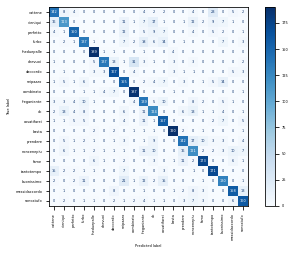

<Figure size 324000x324000 with 0 Axes>

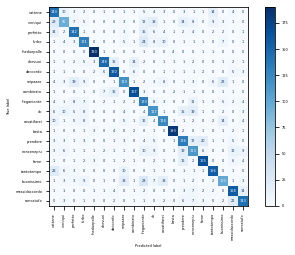

<Figure size 324000x324000 with 0 Axes>

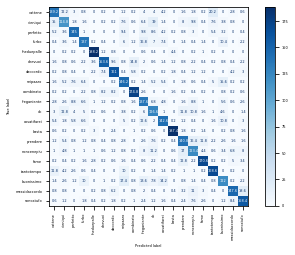

In [106]:
nb_classes = 20
print("===============================")
print("Results for CNNLSTM - best case")
best = np.argmax(test_scores)
print("Accuracy:", round(test_scores[best], 5))
print("F1:", round(all_f1[best], 5))
print("===============================")
displayConfMat(all_confusion[best], "montalbano_snapture_best_30_70_4_9_2021.png")

print("===============================")
print("Results for CNNLSTM - worst case")
worst = np.argmin(test_scores)
print("Accuracy:", round(test_scores[worst], 5))
print("F1:", round(all_f1[worst], 5))
print("===============================")
displayConfMat(all_confusion[worst], "montalbano_snapture_worst_30_70_4_9_2021.png")

print("===============================")
print("Results for CNNLSTM - avg case")
worst = np.mean(test_scores)
print("Accuracy:", round(np.mean(test_scores), 5))
print("F1:", round(np.mean(all_f1), 5))
print("===============================")
temp = []
for conf in all_confusion:
    temp.append(np.array(conf))
#print(np.mean(np.array(temp), axis=0))
displayConfMat(np.mean(np.array(temp), axis=0), "montalbano_snapture_avg_30_70_4_9_2021.png")


In [72]:
#let's save the model
torch.save(model.state_dict(), "/saved_model")

In [108]:
#let's save the model
torch.save(all_models[0].state_dict(), "/model1_4_9_2021")

In [109]:
#let's save the model
torch.save(all_models[1].state_dict(), "/model2_4_9_2021")

In [110]:
#let's save the model
torch.save(all_models[2].state_dict(), "/model3_4_9_2021")

In [111]:
#let's save the model
torch.save(all_models[3].state_dict(), "/model4_4_9_2021")

In [112]:
#let's save the model
torch.save(all_models[4].state_dict(), "/model5_4_9_2021")

In [42]:
def mse(img1, img2):
    err = np.sum((img1.astype("float") - img2.astype("float")) ** 2)
    err /= float(img1.shape[0] * img2.shape[1])
    return err

def diffImg(t0, t1):
    return cv2.absdiff(t0.cpu().numpy(), t1.cpu().numpy())

def getdiffDir(imgs):
    #print(np.shape(imgs))
    diff = []
    all_ssim = []
    all_mse = []
    t = diffImg(imgs[0], imgs[1])
    for i, img in enumerate(imgs[2:-1]):
        #print("ssim", ssim(img, imgs[0]))
        im = diffImg(imgs[i-1], img)
        t += im
        all_ssim.append(1 - ssim(img.cpu().numpy().reshape(64,48), imgs[0].cpu().numpy().reshape(64,48)))
        all_mse.append(mse(img.cpu().numpy().reshape(64,48), imgs[0].cpu().numpy().reshape(64,48)))
    diff.append(t)
    return all_ssim, all_mse, diff

In [43]:
#sequence level
class CNNLSTMwPause(Module):        
    def __init__(
            self,
            input_size=500, 
            hidden_size=512,
            hidden_size_snapture=512,
            num_layers=2,
            batch_first=True,
            num_units=512,
            num_units_snapture=1012,
            num_classes=20,
            snapture=True
    ):
        super(CNNLSTMwPause, self).__init__()
        #cnn for static part
        if snapture:
            #cnn for frames
            self.snap = Snap().to('cuda:0')
            self.snap.double()
    
        #cnn for frames
        self.cnn = CNN().to('cuda:0')
        self.cnn.double()
        
        self.dropout1 = nn.Dropout()
        self.dropout1.double()
        
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.batch_first=batch_first
        self.num_units=num_units
        self.num_classes=num_classes
        self.snapture=snapture
        
        self.rnn = LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=batch_first).to('cuda:0')
        
        weights_init(self.rnn)
      
        self.rnn.double()
        
        self.dropout2 = nn.Dropout()
        self.dropout2.double()
        
        self.act3 = Tanh()
        self.linearCNNLSTMONLY = Linear(512,num_classes).to('cuda:0')
        self.linearCNNLSTMONLY.double()
        self.linear2 = Linear(num_units_snapture,hidden_size_snapture).to('cuda:0')
        self.linear2.double()
        self.dropout3 = nn.Dropout()
        self.dropout3.double()
        self.act4 = Tanh()
        self.linear3 = Linear(hidden_size_snapture,num_classes).to('cuda:0')
        self.linear3.double()

    def forward(self, x, gesture_peak):
        x = x.contiguous()
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        c_out = self.dropout1(c_out)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, (h_n, h_c) = self.rnn(r_in)
        r_out = self.dropout2(r_out)
        
        use_snapture=np.ones((20), dtype=bool)
        for use in use_snapture:
            for sequence in range(len(x)):
                seq = x[sequence]

                kendon_stroke_index = round(len(seq) / 2)
                seq = seq[kendon_stroke_index-2:kendon_stroke_index+2]
                all_error = []
                all_ssim, all_mse, diff = getdiffDir(seq)
                if (np.mean(all_ssim) < 0.027 ):
                    use_snapture[use] = True
                else:
                    use_snapture[use] = False

        r_out2 = self.linearCNNLSTMONLY(r_out[:, -1, :])        
        
        for iitem, item in enumerate(use_snapture):
            if item:
                gesture_peak_maps = self.snap(gesture_peak)
                gesture_peak_maps = torch.cat((r_out[:, -1, :], gesture_peak_maps), dim=1)
                temp = self.linear2(gesture_peak_maps[iitem])
                temp= self.act4(temp)
                temp = self.dropout3(temp)
                r_out2[iitem] = self.linear3(temp)
        
        return F.log_softmax(r_out2, dim=1)

In [44]:
# defining the model
modelwpause = CNNLSTMwPause()
modelwpause.to('cuda:0')
optimizer = Adam(modelwpause.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
    
print(modelwpause)

CNNLSTMwPause(
  (snap): Snap(
    (conv1): Conv2d(1, 5, kernel_size=(11, 11), stride=(1, 1))
    (act1): Tanh()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(5, 10, kernel_size=(6, 6), stride=(1, 1))
    (act2): Tanh()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=770, out_features=500, bias=True)
    (act3): Tanh()
  )
  (cnn): CNN(
    (conv1): Conv2d(1, 5, kernel_size=(11, 11), stride=(1, 1))
    (bn1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): Tanh()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(5, 10, kernel_size=(6, 6), stride=(1, 1))
    (bn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): Tanh()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0

In [45]:
def cnnlstm_montalwpause(num_trials, cv_split):
    num_epochs = 100
    cv_result_extended = []
    test_scores = []
    run_times = []
    pred_history = []
    true_history = []
    
    run_times = []
    test_scores = []
    all_confusion = []
    pred_history = []
    true_history = []
    loss_list = []
    acc_per_epoch = []
    all_models = []

    for i in range(num_trials):


        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0,  drop_last=True, )
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=0,  drop_last=True,)
        modelwpause = CNNLSTMwPause()
        modelwpause = modelwpause.double()
        optimizer = Adam(modelwpause.parameters(), lr=0.001)
        criterion = CrossEntropyLoss()

        start = time.process_time() 
        print(device)
        loss_list, val_losses, this_model = train_model(modelwpause, optimizer, num_epochs, train_loader, test_loader, device)#should be val
        a, b, c, d = test_model(modelwpause, train_loader, device)
        acc, preds, labels, confusion_matrix = test_model(modelwpause, test_loader, device)
        test_scores.append(acc)
        run_times.append(time.process_time() - start)
        pred_history.append(preds)
        true_history.append(labels)
        all_confusion.append(confusion_matrix)
        all_models.append(this_model)

    return run_times, test_scores, pred_history, true_history, loss_list, val_losses, acc, all_confusion, all_models

In [47]:
num_trials = 5
cv_split = 5
run_times_w_pause, test_scores_w_pause, pred_history_w_pause, true_history_w_pause, loss_list_w_pause, val_losses_w_pause, a_w_pause, all_confusion_w_pause, all_models_w_pause = cnnlstm_montalwpause(num_trials, cv_split)

0
Epoch :  1 	 loss : tensor(2.3777, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  3 	 loss : tensor(1.8073, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  5 	 loss : tensor(1.2656, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  7 	 loss : tensor(1.2294, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  9 	 loss : tensor(0.8171, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  11 	 loss : tensor(0.8553, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  13 	 loss : tensor(0.5930, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  15 	 loss : tensor(0.2950, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  17 	 loss : tensor(0.3427, device='cuda:0', dtype=torch.float64, g

KeyboardInterrupt: 

In [ ]:
# we interrupted the last one sine it takes too long to estimate the pause at run time
# we run again with pre pause estimation

In [67]:
#sequence level
class CNNLSTMPause(Module):        
    def __init__(
            self,
            input_size=500, 
            hidden_size=512,
            hidden_size_snapture=512,
            num_layers=2,
            batch_first=True,
            num_units=512,
            num_units_snapture=1012,
            num_classes=20,
            snapture=True
    ):
        super(CNNLSTMPause, self).__init__()
        #cnn for static part
        if snapture:
            #cnn for frames
            self.snap = Snap().to('cuda:0')
            self.snap.double()
    
        #cnn for frames
        self.cnn = CNN().to('cuda:0')
        self.cnn.double()
        
        self.dropout1 = nn.Dropout()
        self.dropout1.double()
        
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.batch_first=batch_first
        self.num_units=num_units
        self.num_classes=num_classes
        self.snapture=snapture
        
        self.rnn = LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=batch_first).to('cuda:0')
        
        weights_init(self.rnn)
      
        self.rnn.double()
        
        self.dropout2 = nn.Dropout()
        self.dropout2.double()
        
        self.act3 = Tanh()
        self.linearCNNLSTMONLY = Linear(512,num_classes).to('cuda:0')
        self.linearCNNLSTMONLY.double()
        
        self.linear2 = Linear(num_units_snapture,hidden_size_snapture).to('cuda:0')
        self.linear2.double()
        self.dropout3 = nn.Dropout()
        self.dropout3.double()
        self.act4 = Tanh()
        self.linear3 = Linear(hidden_size_snapture,num_classes).to('cuda:0')
        self.linear3.double()

    def forward(self, x, gesture_peak, use_snapture):
        x = x.contiguous()
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        c_out = self.dropout1(c_out)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, (h_n, h_c) = self.rnn(r_in)
        r_out = self.dropout2(r_out)
        
        r_out2 = self.linearCNNLSTMONLY(r_out[:, -1, :])        
        
        for iitem, item in enumerate(use_snapture):
            if item:
                gesture_peak_maps = self.snap(gesture_peak)
                gesture_peak_maps = torch.cat((r_out[:, -1, :], gesture_peak_maps), dim=1)
                temp = self.linear2(gesture_peak_maps[iitem])
                temp= self.act4(temp)
                temp = self.dropout3(temp)
                r_out2[iitem] = self.linear3(temp)
                
        return F.log_softmax(r_out2, dim=1)

In [68]:
# defining the model
model = CNNLSTMPause()
model.to('cuda:0')
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
    
print(model)

CNNLSTMPause(
  (snap): Snap(
    (conv1): Conv2d(1, 5, kernel_size=(11, 11), stride=(1, 1))
    (act1): Tanh()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(5, 10, kernel_size=(6, 6), stride=(1, 1))
    (act2): Tanh()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=770, out_features=500, bias=True)
    (act3): Tanh()
  )
  (cnn): CNN(
    (conv1): Conv2d(1, 5, kernel_size=(11, 11), stride=(1, 1))
    (bn1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): Tanh()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(5, 10, kernel_size=(6, 6), stride=(1, 1))
    (bn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): Tanh()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0,

In [69]:
def train_model(model, optimizer, num_epochs, train_loader, val_loader, device):
    
    model.train()
    loss_list = []
    val_losses = []
    for epoch in range(num_epochs):
        #for i, (images, labels, paths, labelindex, kendon, names) in enumerate(train_loader):
        for i, train_data in enumerate(train_loader):
            images, labels, gesture_peak, use_snapture = train_data[0].to('cuda:0'), train_data[1].to('cuda:0'), train_data[4].to('cuda:0'), train_data[5].to('cuda:0')
            outputs = model(images.double(), gesture_peak.double(), use_snapture.double()).to('cuda:0') #statless

            loss = criterion(outputs, labels)
            loss_list.append(float(loss.item()))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch%2 == 0:
            print('Epoch : ',epoch+1, '\t', 'loss :', loss, '\t', 'val_loss :', 0)
    return loss_list, val_losses, model
    
    
def test_model(model, test_loader, device):
    num_correct = 0
    total = 0
    confusion_matrix = torch.zeros(20, 20)
    model.eval()
    with torch.no_grad():
        for test_data in test_loader:
            data, labels, gesture_peak, use_snapture = test_data[0].to('cuda:0'), test_data[1].to('cuda:0'), test_data[4].to('cuda:0'), test_data[5].to('cuda:0')
            predictions = model(data.double(), gesture_peak.double(), use_snapture.double()).to('cuda:0') #statelss
            _, predicted = torch.max(predictions.data, 1)
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            num_correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc_on_test = float(num_correct)/float(total)
    
    print(f"Test Accuracy of the model: {acc_on_test*100:.2f}")
    return acc_on_test, [], [], confusion_matrix
    

In [70]:
def cnnlstm_montal_pause(num_trials, cv_split):
    num_epochs = 100
    cv_result_extended = []
    test_scores = []
    run_times = []
    pred_history = []
    true_history = []
    
    run_times = []
    test_scores = []
    all_confusion = []
    pred_history = []
    true_history = []
    loss_list = []
    acc_per_epoch = []
    all_models = []

    for i in range(num_trials):
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0,  drop_last=True, )
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=0,  drop_last=True,)
        model = CNNLSTMPause()
        model = model.double()
        optimizer = Adam(model.parameters(), lr=0.001)
        criterion = CrossEntropyLoss()

        start = time.process_time() 
        print(device)
        loss_list, val_losses, this_model = train_model(model, optimizer, num_epochs, train_loader, test_loader, device)#should be val
        a, b, c, d = test_model(model, train_loader, device)
        acc, preds, labels, confusion_matrix = test_model(model, test_loader, device)
        test_scores.append(acc)
        run_times.append(time.process_time() - start)
        pred_history.append(preds)
        true_history.append(labels)
        all_confusion.append(confusion_matrix)
        all_models.append(this_model)

    return run_times, test_scores, pred_history, true_history, loss_list, val_losses, acc, all_confusion, all_models


In [ ]:
num_trials = 5
cv_split = 5
run_times_pause, test_scores_pause, pred_history_pause, true_history_pause, loss_list_pause, val_losses_pause, a_pause, all_confusion_pause, all_models_pause = cnnlstm_montal_pause(num_trials, cv_split)

0
Epoch :  1 	 loss : tensor(1.8171, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  3 	 loss : tensor(1.2976, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  5 	 loss : tensor(0.6462, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  7 	 loss : tensor(0.6452, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0


In [72]:
print(a_pause)
print(test_scores_pause)
print(np.mean(test_scores_pause))

0.7585685483870968
[0.7626008064516129, 0.7779737903225806, 0.7734375, 0.7779737903225806, 0.7585685483870968]
0.7701108870967742
The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


In [73]:
print("mean test scores ", np.mean(test_scores_pause))
print("std test scores ", np.std(test_scores_pause))
print("best case test scores ", np.max(test_scores_pause))
print("worst case test scores ", np.min(test_scores_pause))

mean test scores  0.7701108870967742
std test scores  0.008054113754727428
best case test scores  0.7779737903225806
worst case test scores  0.7585685483870968


In [74]:
print(run_times_pause)
print("mean training time: ", np.mean(run_times_pause))
print("std training time: ", np.std(run_times_pause))

[44664.291611921, 44779.30118971701, 44657.74700256699, 44690.81897405902, 44693.77633712199]
mean training time:  44697.187023077204
std training time:  43.43396017614419


In [75]:
print(all_confusion_pause)

[tensor([[163.,   5.,   4.,   2.,   0.,   0.,   0.,   2.,   0.,   3.,   3.,   3.,
           0.,   0.,   3.,   0.,   5.,   0.,   1.,   1.],
        [ 17.,  97.,   2.,   0.,   0.,   0.,   0.,  10.,   0.,   5.,  36.,   1.,
           0.,   5.,  17.,   0.,   4.,   5.,   0.,   0.],
        [  6.,   1., 158.,   0.,   1.,   0.,   0.,   2.,   0.,  15.,   8.,   2.,
           0.,   1.,   2.,   0.,   2.,   3.,   0.,   0.],
        [  0.,   0.,   1., 163.,   0.,   1.,   0.,   5.,   1.,  13.,   4.,   2.,
           0.,   0.,   1.,   0.,   0.,   8.,   0.,   0.],
        [  0.,   0.,   0.,   1., 187.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,
           2.,   1.,   1.,   2.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   4.,   4.,   2., 156.,   4.,   0.,  17.,   3.,   2.,   0.,
           0.,   0.,   2.,   0.,   0.,   3.,   0.,   3.],
        [  0.,   0.,   1.,   1.,   0.,  10., 162.,   0.,   7.,   0.,   0.,   0.,
           2.,   1.,   1.,   1.,   0.,   0.,   2.,   3.],
        [  3.,   3.,   8.,

In [76]:
print(all_confusion_pause[0])

tensor([[163.,   5.,   4.,   2.,   0.,   0.,   0.,   2.,   0.,   3.,   3.,   3.,
           0.,   0.,   3.,   0.,   5.,   0.,   1.,   1.],
        [ 17.,  97.,   2.,   0.,   0.,   0.,   0.,  10.,   0.,   5.,  36.,   1.,
           0.,   5.,  17.,   0.,   4.,   5.,   0.,   0.],
        [  6.,   1., 158.,   0.,   1.,   0.,   0.,   2.,   0.,  15.,   8.,   2.,
           0.,   1.,   2.,   0.,   2.,   3.,   0.,   0.],
        [  0.,   0.,   1., 163.,   0.,   1.,   0.,   5.,   1.,  13.,   4.,   2.,
           0.,   0.,   1.,   0.,   0.,   8.,   0.,   0.],
        [  0.,   0.,   0.,   1., 187.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,
           2.,   1.,   1.,   2.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   4.,   4.,   2., 156.,   4.,   0.,  17.,   3.,   2.,   0.,
           0.,   0.,   2.,   0.,   0.,   3.,   0.,   3.],
        [  0.,   0.,   1.,   1.,   0.,  10., 162.,   0.,   7.,   0.,   0.,   0.,
           2.,   1.,   1.,   1.,   0.,   0.,   2.,   3.],
        [  3.,   3.,   8., 

In [77]:
print(all_confusion_pause[1])

tensor([[156.,   9.,   2.,   1.,   0.,   0.,   0.,   2.,   0.,   4.,   1.,   6.,
           0.,   0.,   1.,   0.,  12.,   1.,   1.,   0.],
        [ 11., 120.,   3.,   2.,   0.,   0.,   0.,   9.,   0.,   8.,  22.,   0.,
           0.,   4.,   4.,   0.,   7.,   7.,   0.,   2.],
        [  8.,   4., 142.,   1.,   0.,   0.,   0.,   7.,   0.,  12.,   8.,   3.,
           0.,   0.,   2.,   1.,   6.,   7.,   0.,   0.],
        [  0.,   4.,   0., 151.,   0.,   0.,   0.,   5.,   0.,  13.,   5.,   7.,
           0.,   0.,   1.,   1.,   0.,  12.,   0.,   0.],
        [  0.,   0.,   0.,   0., 192.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
           4.,   0.,   1.,   0.,   0.,   0.,   0.,   0.],
        [  2.,   0.,   0.,   3.,   1., 151.,  10.,   0.,  15.,   2.,   0.,   3.,
           1.,   0.,   5.,   0.,   0.,   1.,   0.,   5.],
        [  0.,   0.,   0.,   0.,   4.,   2., 173.,   0.,   5.,   0.,   0.,   0.,
           0.,   0.,   2.,   0.,   0.,   0.,   3.,   2.],
        [  1.,   3.,   6., 

In [78]:
print(all_confusion_pause[2])

tensor([[142.,  11.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   3.,
           0.,   1.,   2.,   0.,  27.,   0.,   2.,   0.],
        [ 12., 121.,   2.,   1.,   0.,   0.,   0.,   7.,   0.,   2.,  23.,   2.,
           0.,   8.,   6.,   0.,   9.,   7.,   0.,   0.],
        [  3.,   2., 154.,   0.,   0.,   0.,   0.,  15.,   0.,   3.,  10.,   1.,
           0.,   1.,   1.,   0.,   5.,   5.,   0.,   0.],
        [  0.,   5.,   1., 139.,   0.,   1.,   0.,  15.,   0.,   9.,   7.,   6.,
           1.,   2.,   0.,   1.,   1.,  10.,   0.,   1.],
        [  0.,   0.,   0.,   0., 192.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
           2.,   0.,   0.,   1.,   0.,   0.,   0.,   1.],
        [  0.,   0.,   0.,   3.,   2., 160.,   8.,   0.,   8.,   3.,   0.,   1.,
           1.,   0.,   2.,   0.,   0.,   6.,   0.,   4.],
        [  0.,   0.,   0.,   0.,   4.,   7., 167.,   0.,   5.,   1.,   1.,   0.,
           0.,   0.,   1.,   1.,   0.,   0.,   1.,   2.],
        [  2.,   8.,   5., 

In [79]:
print(all_confusion_pause[3])

tensor([[158.,   5.,   6.,   1.,   0.,   0.,   0.,   0.,   0.,   3.,   1.,   1.,
           1.,   1.,   2.,   0.,  12.,   1.,   3.,   0.],
        [ 18., 116.,   1.,   2.,   0.,   1.,   0.,   5.,   0.,   3.,  20.,   1.,
           0.,   8.,   9.,   1.,   4.,   9.,   0.,   2.],
        [  5.,   1., 142.,   3.,   1.,   1.,   0.,   7.,   0.,  12.,   7.,   4.,
           0.,   2.,   1.,   0.,   6.,   7.,   0.,   1.],
        [  0.,   5.,   0., 152.,   0.,   0.,   0.,   4.,   1.,  17.,   3.,   5.,
           0.,   0.,   1.,   1.,   0.,  10.,   0.,   0.],
        [  0.,   0.,   0.,   0., 190.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
           4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   1.,   0.,   2.,   3., 157.,  11.,   0.,  19.,   2.,   1.,   0.,
           2.,   0.,   0.,   0.,   0.,   2.,   0.,   1.],
        [  0.,   0.,   0.,   0.,   2.,   7., 169.,   0.,   6.,   0.,   0.,   0.,
           2.,   0.,   1.,   1.,   0.,   0.,   1.,   2.],
        [  2.,  12.,   3., 

In [80]:
print(all_confusion_pause[4])

tensor([[145.,   6.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   4.,   0.,
           0.,   2.,   1.,   1.,  27.,   2.,   2.,   1.],
        [ 10., 109.,   3.,   2.,   0.,   0.,   0.,   9.,   1.,   3.,  30.,   0.,
           0.,   7.,   6.,   0.,  12.,   6.,   0.,   0.],
        [  6.,   2., 145.,   1.,   0.,   0.,   0.,  14.,   0.,   2.,  12.,   2.,
           0.,   1.,   3.,   0.,   3.,  10.,   0.,   0.],
        [  0.,   3.,   2., 156.,   0.,   0.,   0.,   5.,   2.,   7.,   7.,   6.,
           0.,   1.,   1.,   1.,   1.,   7.,   0.,   0.],
        [  0.,   0.,   1.,   0., 180.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          11.,   0.,   0.,   3.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   2.,   1., 164.,   5.,   0.,   7.,   5.,   0.,   0.,
           6.,   1.,   1.,   2.,   0.,   1.,   0.,   6.],
        [  0.,   0.,   0.,   1.,   2.,  12., 156.,   0.,   6.,   1.,   0.,   0.,
           5.,   0.,   1.,   1.,   0.,   0.,   4.,   3.],
        [  0.,   2.,   5., 

In [82]:
all_f1 = []
for conf in all_confusion_pause:
    recall = np.diag(conf.numpy()) / np.sum(conf.numpy(), axis = 1)
    precision = np.diag(conf.numpy()) / np.sum(conf.numpy(), axis = 0)
    recall = np.mean(recall)
    precision = np.mean(precision)
    all_f1.append(2 * (precision * recall) / (precision + recall))

In [83]:
print(all_f1)
print("f1 score: ", np.mean(all_f1))
print("f1 score: ", np.std(all_f1))

[0.7674388008698354, 0.7792753670743345, 0.774270368373701, 0.7786558686999252, 0.7618868433470727]
f1 score:  0.7723054496729738
f1 score:  0.006708205486526485


In [84]:
temp = []
for conf in all_confusion_pause:
    temp.append(np.array(conf))
print(np.mean(np.array(temp), axis=0))

[[152.8   7.2   3.8   1.2   0.    0.    0.    0.8   0.    2.4   2.2   2.6
    0.2   0.8   1.8   0.2  16.6   0.8   1.8   0.4]
 [ 13.6 112.6   2.2   1.4   0.    0.2   0.    8.    0.2   4.2  26.2   0.8
    0.    6.4   8.4   0.2   7.2   6.8   0.    0.8]
 [  5.6   2.  148.2   1.    0.4   0.2   0.    9.    0.    8.8   9.    2.4
    0.    1.    1.8   0.2   4.4   6.4   0.    0.2]
 [  0.    3.4   0.8 152.2   0.    0.4   0.    6.8   0.8  11.8   5.2   5.2
    0.2   0.6   0.8   0.8   0.4   9.4   0.    0.2]
 [  0.    0.    0.2   0.2 188.2   1.    0.8   0.2   0.    0.    0.    0.
    4.6   0.2   0.4   1.2   0.    0.    0.    0.2]
 [  0.4   0.2   0.8   2.8   1.8 157.6   7.6   0.   13.2   3.    0.6   0.8
    2.    0.2   2.    0.4   0.    2.6   0.    3.8]
 [  0.    0.    0.2   0.4   2.4   7.6 165.4   0.    5.8   0.4   0.2   0.
    1.8   0.2   1.2   0.8   0.    0.    2.2   2.4]
 [  1.6   5.6   5.4   7.6   0.    0.    0.  148.2   0.    0.8   6.2   4.4
    0.    1.6   0.6   0.6   5.   15.8   0.2   0.2]
 [

In [85]:
from matplotlib.pyplot import figure
def displayConfMat(confusion_matrix, save_file_name):
    font = {'size'   : 3.5}
    plt.rc('font', **font)
    figure(num=None, figsize=(1080, 1080), dpi=300, facecolor='w', edgecolor='k')
    plt_conf = ConfusionMatrixDisplay(confusion_matrix=np.array(confusion_matrix),
                                  display_labels=np.array(classes))
    plt_conf.plot(xticks_rotation='vertical', cmap='Blues',values_format='.5g')
    plt.gcf().subplots_adjust(bottom=0.19)
    plt_conf.figure_.savefig(save_file_name, dpi=300)
    

Results for CNNLSTM - best case
Accuracy: 0.77797
F1: 0.77928
Results for CNNLSTM - worst case
Accuracy: 0.75857
F1: 0.76189
Results for CNNLSTM - avg case
Accuracy: 0.77011
F1: 0.77231


<Figure size 324000x324000 with 0 Axes>

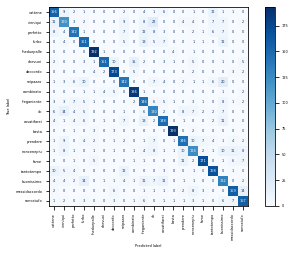

<Figure size 324000x324000 with 0 Axes>

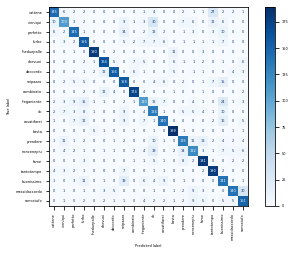

<Figure size 324000x324000 with 0 Axes>

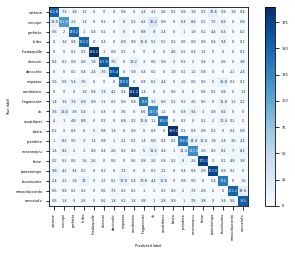

In [86]:
nb_classes = 20
print("===============================")
print("Results for CNNLSTM - best case")
best = np.argmax(test_scores_pause)
print("Accuracy:", round(test_scores_pause[best], 5))
print("F1:", round(all_f1[best], 5))
print("===============================")
displayConfMat(all_confusion_pause[best], "montalbano_pause_best_12_9_2021.png")

print("===============================")
print("Results for CNNLSTM - worst case")
worst = np.argmin(test_scores_pause)
print("Accuracy:", round(test_scores_pause[worst], 5))
print("F1:", round(all_f1[worst], 5))
print("===============================")
displayConfMat(all_confusion_pause[worst], "montalbano_pause_worst_12_9_2021.png")

print("===============================")
print("Results for CNNLSTM - avg case")
worst = np.mean(test_scores_pause)
print("Accuracy:", round(np.mean(test_scores_pause), 5))
print("F1:", round(np.mean(all_f1), 5))
print("===============================")
temp = []
for conf in all_confusion_pause:
    temp.append(np.array(conf))
displayConfMat(np.mean(np.array(temp), axis=0), "montalbano_pause_avg_12_9_2021.png")

In [87]:
#let's save the model
torch.save(all_models_pause[0].state_dict(), "/model_pause_1_12_9_2021")

In [88]:
torch.save(all_models_pause[1].state_dict(), "/model_pause_2_12_9_2021")

In [89]:
torch.save(all_models_pause[2].state_dict(), "/model_pause_3_12_9_2021")

In [90]:
torch.save(all_models_pause[3].state_dict(), "/model_pause_4_12_9_2021")

In [91]:
torch.save(all_models_pause[4].state_dict(), "/model_pause_5_12_9_2021")